In [271]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import stats

# Read in dorcs 


In [272]:
dorcs= pd.read_csv("1-s2.0-S0092867420312538-mmc4.csv", sep = ",")

In [273]:
chroms = [i.split('_')[0] for i in dorcs['peak']]

In [274]:
dorcs['Chr'] = chroms

In [275]:
x = dorcs['Gene'].value_counts(dropna=True)
y = dorcs['Gene'].value_counts(dropna=True).index
dorclist = []
dorcnums = []
z = x.index
for i in range(len(x)):
    if x[i] > 10:
        dorclist.append(z[i])
        dorcnums.append(x[i])
dorcs["region"] = dorcs['Chr'] + "_" + (dorcs["Start"].astype(int) + 1).astype(str) + "_" + dorcs["End"].astype(str)
#dorclist

# Read in counts of atac peaks: Normalize the peak matrix - log normalize using lognormalize functon in r before loading in ^^^

In [278]:
#reading in the cell by peak matrix
peaks = pd.read_csv("GSM4156597_skin.late.anagen.peaks.bed", sep= "\t", header = None)
peaks.columns = ["chr", "start", "end"]
peaks["start"] = peaks["start"] + 1
peaks["region"] = peaks["start"].astype(str) + "_" + peaks["end"].astype(str)
peaks["total"] = peaks["chr"].astype(str) + "_" + peaks["region"].astype(str)


In [279]:
counts = sio.mmread("GSM4156597_skin.late.anagen.counts.txt")
cell_ids = pd.read_csv("GSM4156597_skin_celltype.txt", header = 0, sep = "\t")
cell_idrna = cell_ids['rna.bc']
cell_ids =cell_ids['atac.bc']


In [199]:
cell_ids = cell_ids['x']
cell_idrna = cell_idrna['x']
#cell_idrna = cell_ids['rna.bc']
#cell_ids = cell_ids['atac.bc']
#bedfile <- data(counts, package = "chromVAR")


KeyError: 'x'

In [280]:
counts.columns = cell_ids
counts.rows = peaks['total']

# find the dorc scores to create the dorc x cell matrix

In [281]:
counts.rows.head()

0    chrX_143482907_143483206
1        chr6_3200977_3201276
2    chr9_123461851_123462150
3      chr1_56782096_56782395
4      chr9_56223669_56223968
Name: total, dtype: object

In [282]:
dorcs['region'] = [i.split('_')[0] + '_' + str(int(i.split('_')[1]) + 1) + '_' + i.split('_')[2] for i in dorcs['region']]

In [283]:
#for each gene in dorclist
dorc_by_cell = []
for i in dorclist:
    #find all associated peak names from the table above,find them in the count matrix and sum their arrays into 1
    peak_names = dorcs[dorcs['Gene'] == i]['region'].tolist()
    geneind2 = [j for j, e in enumerate(counts.rows) if e in peak_names]
    corr = counts.tocsr()[geneind2, : ]
    corr = corr.toarray()
    corr = np.sum(corr, axis = 0)
    #print(corr)
    #add this to a new dorc_matrix with the same cell columns
    dorc_by_cell.append((i, corr))
    #print(i)

In [284]:
dorc_by_cell = pd.DataFrame(dorc_by_cell)
dorc_by_cell.head()

,0,1
0,Notch1,"[0, 1, 0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 0, ..."
1,Emp1,"[0, 0, 1, 2, 0, 0, 1, 0, 7, 2, 1, 0, 0, 0, 0, ..."
2,Cux1,"[0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, ..."
3,Ezr,"[0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Col3a1,"[1, 1, 1, 2, 1, 0, 1, 0, 2, 0, 2, 1, 0, 1, 0, ..."


In [285]:
dorc_by_cell.columns = ['gene', 'cell']
dorc_by_cell.index = dorc_by_cell['gene']
dorc_by_cell = dorc_by_cell[['cell']]

# read in rna counts

In [238]:
rna_expression = sio.mmread('rna_expression4.mtx')



In [239]:
to_meta = pd.read_csv('features.tsv', sep = '\t', header = 0)

In [240]:
to_meta.columns = ['gene']

In [241]:
rna_expression.rows = to_meta['gene']
rna_expression.columns = cell_idrna

# Create dictionary for indexes of atac cells and rna cells in the dorc cell matrix

In [242]:
todic = counts.columns
todic = dict(todic)
todic = {v: k for k, v in todic.items()}
todic2 = dict(rna_expression.columns)

todic2 = {v: k for k, v in todic2.items()}

#dictionary of cells and their atac index
atac_cells = todic
#dictionary of cells and their rna index
rna_cells = todic2

# read in the topic knn

In [243]:
topics = pd.read_csv('topic.matrix.csv', delimiter = '\t')
topics.head()

,Trial60.skin.R1.01.R2.01.R3.06.P1.55,Trial60.skin.R1.01.R2.03.R3.68.P1.55,Trial60.skin.R1.01.R2.05.R3.15.P1.53,Trial60.skin.R1.01.R2.05.R3.40.P1.55,Trial60.skin.R1.01.R2.05.R3.49.P1.55,Trial60.skin.R1.01.R2.06.R3.14.P1.55,Trial60.skin.R1.01.R2.09.R3.17.P1.54,Trial60.skin.R1.01.R2.11.R3.27.P1.54,Trial60.skin.R1.01.R2.12.R3.50.P1.54,Trial60.skin.R1.01.R2.13.R3.24.P1.54,...,Trial60.skin.R1.91.R2.61.R3.24.P1.54,Trial60.skin.R1.91.R2.89.R3.05.P1.53,Trial60.skin.R1.92.R2.28.R3.67.P1.56,Trial60.skin.R1.92.R2.36.R3.69.P1.53,Trial60.skin.R1.92.R2.69.R3.22.P1.53,Trial60.skin.R1.92.R2.79.R3.05.P1.56,Trial60.skin.R1.93.R2.20.R3.18.P1.53,Trial60.skin.R1.93.R2.80.R3.62.P1.55,Trial60.skin.R1.93.R2.91.R3.82.P1.56,Trial60.skin.R1.94.R2.75.R3.40.P1.55
Topic1,0.059573,0.115929,0.096909,0.058176,0.089527,0.062683,0.145751,0.113575,0.071527,0.099691,...,0.104023,0.020935,0.210407,0.047316,0.070249,0.071842,0.032515,0.046531,0.097605,0.070463
Topic2,0.044501,0.010027,0.027378,0.023606,0.020505,0.013993,0.054002,0.020445,0.025584,0.013652,...,0.046202,0.014110,0.046513,0.020455,0.051858,0.050436,0.029044,0.013905,0.099103,0.066249
Topic3,0.003217,0.032631,0.010982,0.011513,0.001606,0.012614,0.024880,0.006663,0.006955,0.002311,...,0.012726,0.015169,0.004084,0.004231,0.035767,0.018580,0.012386,0.018477,0.036931,0.023337
Topic4,0.005838,0.012120,0.005793,0.013795,0.007769,0.015266,0.001238,0.000607,0.019021,0.003875,...,0.006640,0.006108,0.005748,0.013806,0.020660,0.004819,0.004156,0.004137,0.007218,0.003413
Topic5,0.003217,0.002911,0.007661,0.015278,0.003660,0.003915,0.000612,0.008960,0.014049,0.009742,...,0.000553,0.017994,0.004916,0.033221,0.014092,0.003545,0.010303,0.036972,0.000726,0.011076


In [244]:
import sklearn.neighbors as sk
topicknn = sk.kneighbors_graph(topics.transpose(), mode='connectivity', n_neighbors=50)

In [245]:
topicknn.columns = cell_ids
topicknn.rows = cell_ids


In [246]:
topicknn

<34774x34774 sparse matrix of type '<class 'numpy.float64'>'
	with 1738700 stored elements in Compressed Sparse Row format>

In [247]:
topicknn.rows = topicknn.rows.reset_index(drop = True)
topicknn.columns = topicknn.columns.reset_index(drop = True)

In [248]:
topicdict = {}
for i in range(len(topicknn.rows)):
    row = topicknn.tocsr()[i, :].toarray()
    indexes = []
    [indexes.append(j) for j in range(len(row[0])) if row[0][j] > 0]
    topicdict[topicknn.rows[i]] = indexes

# create rna x cell modified matrix

In [249]:
rna_expression

<23296x34774 sparse matrix of type '<class 'numpy.float64'>'
	with 22350084 stored elements in COOrdinate format>

In [250]:
rind = [j for j, e in enumerate(rna_expression.rows.tolist()) if e in dorc_by_cell.index.tolist()]

In [251]:

rna_expression = rna_expression.tocsr()[rind, : ]
rna_expression.columns = cell_idrna

In [252]:

rna_expression.rows = to_meta['gene'][rind]
rna_by_cell = pd.DataFrame(rna_expression.todense())
rna_by_cell = rna_by_cell.values.tolist()

In [253]:

rna_by_cell2 = pd.DataFrame(rna_expression.rows)
rna_by_cell2 = rna_by_cell2.reset_index(drop=True)
rna_by_cell2['cell'] = [i for i in rna_by_cell]
rna_by_cell2.index = rna_by_cell2['gene']
rna_by_cell2 = rna_by_cell2[['cell']]
rna_by_cell2.head()

,cell
gene,
1810011O10Rik,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2210411M09Rik,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2610035D17Rik,"[0.0, 2.285044688700701, 0.0, 0.0, 0.0, 0.0, 0..."
2810030D12Rik,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2900026A02Rik,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.5319370085144932, ..."


In [143]:
#dorc_by_cell = pd.read_csv('dorc_by_cell.csv')

# smooth functions

In [257]:
def Avg(array, knn):
    toreturn = []
    for i in range(len(array)):
        val = topicknn.rows[i]
        inds = knn.get(val)
        total = int(array[i])
        for num in inds:
            total += array[num]
        total = (total/(1 + len(inds)) )
        toreturn.append(total)
    return toreturn

In [258]:
def smooth(dataframe, knn):
    count = 0
    #dataframe is a dorc x cell matrix or a rna x cell matrix
    #make sure if rna x cell matrix, we only use the dorc rnas 
    print(len(dataframe.index))
    newmat = []
    for key, value in dataframe.iterrows():
        rep = value[0]
        newrep = Avg(rep, knn)
        newmat.append((key, newrep))    
        
        #genename = key
        #geneind2 = [j for j, e in enumerate(tempy) if i == e]
        #corr = counts.tocsr()[geneind2, : ]
        #corr = corr.toarray()
        if count % 200 == 0:
            print(len(newmat))
        count += 1
    return(newmat)

# normalize our dorc matrix by peak counts - dont do this



In [ ]:
#curr = [0 for i in range(len(dorc_by_cell.iloc[0][0]))]
#for i in dorc_by_cell['cell']:
#    zipped_lists = zip(i, curr)
#    curr = [x + y for (x, y) in zipped_lists]

In [ ]:
#d2 = []
#for index, row in dorc_by_cell.iterrows():
#    zipped_lists = zip(row['cell'], curr)
#    tp = [np.log(((x / y)*10000)+1) for (x, y) in zipped_lists]
#    d2.append(tp)

#d2 = pd.Series(d2)
#d2.index = dorc_by_cell.index
#dorc_by_cell['cell'] = d2
#dorc_by_cell = dorc_by_cell[['cell']]
#dorc_by_cell.head()

# smooth the dorc scores

In [259]:
#smooth the dorc scores
smoothed_dorc = smooth(dorc_by_cell, topicdict)
#smooth the rna scores

857
1
201
401
601
801


# smooth the rna scores

In [260]:
smoothed_rna = smooth(rna_by_cell2, topicdict)

857
1
201
401
601
801


# get dorc scores and rna in usable formats

In [261]:
smoothed_rna = pd.DataFrame(smoothed_rna)
smoothed_rna.columns = ['gene', 'cell']
smoothed_dorc = pd.DataFrame(smoothed_dorc)
smoothed_dorc.columns = ['gene', 'cell']
revdorc = pd.DataFrame(cell_ids)

In [ ]:
#was trying with more identified dorcs >= 10

In [262]:
matsmoothvals = smoothed_dorc.cell.apply(pd.Series)

In [263]:
matsmoothvals.index = dorc_by_cell.index
matsmoothvals = matsmoothvals.reindex(dorc_by_cell.index)

In [264]:
matsmoothvals.head()

,0,1,2,3,4,5,6,7,8,9,...,34764,34765,34766,34767,34768,34769,34770,34771,34772,34773
gene,,,,,,,,,,,,,,,,,,,,,
Notch1,0.279730,0.450000,0.139692,0.440453,0.228379,0.594662,0.391085,0.105586,0.702317,0.557076,...,0.389861,0.852848,0.156783,0.767788,0.495097,0.543240,1.815804,1.665381,0.518777,0.529881
Emp1,1.377394,0.929515,0.708628,0.779310,0.668980,0.990497,0.612192,0.583553,1.090697,0.723754,...,0.228150,0.579898,0.196125,0.435223,0.235297,0.341355,0.632954,0.343178,0.259543,0.324056
Cux1,0.142799,0.237633,0.315237,0.316433,0.209893,0.305983,0.230662,0.265982,0.242461,0.286611,...,0.253120,0.654121,0.195187,0.439499,0.235638,0.405416,0.992977,1.717085,0.369243,0.401603
Ezr,0.226680,0.117173,0.078160,0.505194,0.217456,0.427406,0.149088,0.099382,0.326719,0.176588,...,0.238350,0.389667,0.177946,0.697414,0.380694,0.300832,0.619393,0.328509,0.420152,0.347978
Col3a1,1.367936,0.894577,1.514720,0.414442,1.532768,1.154620,1.303296,1.606660,0.934855,0.790225,...,0.000000,0.024740,0.026186,0.048852,0.000000,0.000000,0.062664,0.125257,0.042240,0.000000


In [265]:
matsmoothvals.to_csv('smoothed_dorc_table_my_umap.csv')

In [266]:
matsmoothvals = smoothed_rna.cell.apply(pd.Series)

In [267]:
matsmoothvals.index = rna_by_cell2.index
matsmoothvals = matsmoothvals.reindex(rna_by_cell2.index)

In [268]:
matsmoothvals.head()

,0,1,2,3,4,5,6,7,8,9,...,34764,34765,34766,34767,34768,34769,34770,34771,34772,34773
gene,,,,,,,,,,,,,,,,,,,,,
1810011O10Rik,0.000000,0.000000,0.000000,0.024691,0.000000,0.000000,0.000000,0.000000,0.024135,0.000000,...,0.000000,0.085558,0.000000,0.014062,0.000000,0.000000,0.057506,0.027684,0.000000,0.000000
2210411M09Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028196,0.000000,0.000000,0.000000
2610035D17Rik,0.116407,0.343902,0.076082,0.445522,0.105774,0.222690,0.000000,0.090479,0.328456,0.307445,...,0.350622,0.546727,0.261444,0.749499,0.386467,0.332733,0.534031,0.101193,0.317929,0.271799
2810030D12Rik,0.000000,0.000000,0.040889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2900026A02Rik,0.257301,0.081348,0.101401,0.192018,0.034432,0.246808,0.205058,0.101401,0.057482,0.081348,...,0.041145,0.358309,0.052159,0.146001,0.068547,0.041145,0.141647,0.102852,0.041145,0.041145


In [269]:
len(matsmoothvals)

857

In [270]:
matsmoothvals.to_csv('smoothed_rna_table_my_umap.csv')

In [357]:
cell_ids.to_csv('foxa1_data/smoothed_dorc_columns_G2.csv', header = False)

# get dorc scores in a usable format

In [24]:
torev= smoothed_dorc['cell'].tolist()


In [25]:
ttl = []
for num in range(len(cell_ids)):
    current = [i[num] for i in torev]
    ttl.append(current)

In [26]:
torev = pd.DataFrame(revdorc)
torev['cell'] = [i for i in ttl]
torev.columns = ['gene', 'cell']
torev.head()

,gene,cell
0,R1.01.R2.01.R3.06.P1.07,"[0.35758890270808635, 0.9269752628817349, 0.26..."
1,R1.01.R2.03.R3.68.P1.07,"[0.48813308295675284, 0.5161800576539798, 0.28..."
2,R1.01.R2.05.R3.15.P1.05,"[0.16342593772709105, 0.6361023923212689, 0.24..."
3,R1.01.R2.05.R3.40.P1.07,"[0.34969012536097777, 0.9331951688499204, 0.22..."
4,R1.01.R2.05.R3.49.P1.07,"[0.37514884698894024, 0.5516189074912695, 0.12..."


# get rna scores in a usable format

In [192]:
torna= smoothed_dorc['cell'].tolist()
ttl = []
for num in range(len(cell_ids)):
    current = [i[num] for i in torna]
    ttl.append(current)
torna = pd.DataFrame(revdorc)
torna['cell'] = [i for i in ttl]
torna.columns = ['gene', 'cell']
torna.index = torna['gene']
torna.head()

,gene,cell
gene,,
R1.01.R2.01.R3.06.P1.07,R1.01.R2.01.R3.06.P1.07,"[0.2797303788279889, 1.3773942882283392, 0.142..."
R1.01.R2.03.R3.68.P1.07,R1.01.R2.03.R3.68.P1.07,"[0.4499995987279155, 0.9295145369521522, 0.237..."
R1.01.R2.05.R3.15.P1.05,R1.01.R2.05.R3.15.P1.05,"[0.1396919136737811, 0.7086278116998733, 0.315..."
R1.01.R2.05.R3.40.P1.07,R1.01.R2.05.R3.40.P1.07,"[0.4404529519612967, 0.7793095804823703, 0.316..."
R1.01.R2.05.R3.49.P1.07,R1.01.R2.05.R3.49.P1.07,"[0.22837919788698074, 0.6689797832693414, 0.20..."


# find the top half of differentially expressed genes

In [ ]:
x = [np.log(np.mean(row['cell'])) for i, row in torev

# get the 50 knns of each in gene column from the sparse matrix, perform 50 correlations choose 10 best (this one takes a while ~20 - 30 min for 20k genes) - need to edit for pearson correlations accross all cells

In [28]:
def GetNeighbors(cellname, knn):
    ids = knn.get(cellname)
    toret = [cell_ids[i] for i in ids]
    return toret

In [31]:
newknn = {}
print(len(torev['gene']))
counter = 0
for i in torev['gene']:
    nn = GetNeighbors(i, topicdict)
    #we now have list of cell ids to perform correlations with
    rnaspace = torna.loc[nn]['cell']#.tolist()
    celllist = rnaspace.index
    rnaspace = rnaspace.tolist()
    chromatin_space = torev.loc[i]['cell']
    spearresults = [stats.pearsonr(x = chromatin_space, y = rna)[0] for rna in rnaspace]
    speardf = pd.DataFrame(zip(celllist,spearresults))
    speardf.columns = ['cell', 'spearman']
    speardf = speardf.sort_values(['spearman'], ascending = False).head(10)
    newknn[i] = speardf['cell'].tolist()
    if counter % 100 == 0:
        print(counter)
    counter += 1

34774
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18

In [ ]:
newknn = {}
for i in torev['gene']:
    nn = GetNeighbors(i, topicdict)
    #we now have list of cell ids to perform correlations with
    rnaspace = torna.loc[nn]['cell']#.tolist()
    celllist = rnaspace.index
    rnaspace = rnaspace.tolist()
    chromatin_space = torev.loc[i]['cell']
    spearresults = [stats.spearmanr(chromatin_space, b = rna, axis = 1)[0] for rna in rnaspace]
    speardf = pd.DataFrame(zip(celllist,spearresults))
    speardf.columns = ['cell', 'spearman']
    speardf = speardf.sort_values(['spearman'], ascending = False).head(10)
    newknn[i] = speardf['cell'].tolist()

# with our new knn graph calculate the distance between each cell and its neighbors using atac seq umap coordinates.

In [32]:
#read in atac seq umap coordinates
atac_umap = pd.read_csv('umap55top.tsv', sep = '\t')
atac_umap.head()

,UMAP1,UMAP2
R1.01.R2.01.R3.06.P1.07,6.594912,-9.484761
R1.01.R2.03.R3.68.P1.07,6.102664,-9.647321
R1.01.R2.05.R3.15.P1.05,6.693468,-9.509410
R1.01.R2.05.R3.40.P1.07,6.464937,-9.584708
R1.01.R2.05.R3.49.P1.07,6.867137,-9.760105


In [33]:
def GetUmaps(nb):
    umaps = []
    for i in nb:
        cell_name = atac_umap.loc[i]
        umaps.append((cell_name['UMAP1'], cell_name['UMAP2']))
    return umaps

In [34]:
import math
def GetEuclideanDistance(coord1, coord2):
    coord1_x = coord1[0]
    coord1_y = coord1[1]
    coord2_x = coord2[0]
    coord2_y = coord2[1]
    distance = math.sqrt(((coord1_x - coord2_x)**2)+((coord1_y-coord2_y)**2))
    return distance
    

In [35]:
def FindCentroid(coordset):
    return np.mean(coordset, axis=0)

In [112]:
#we need to have a umap matrix where every cell has its coordinates
arrowlength = []
endingpoint = []
for i in newknn:
    nbs= newknn.get(i)
    #umaps is a list of the umap coordinates of the neighbors.
    umaps = GetUmaps(nbs)
    distlist = []
    centroid = FindCentroid(umaps)
    endingpoint.append(centroid)
    dist = GetEuclideanDistance(centroid, GetUmaps([i])[0])
    arrowlength.append(dist)
    

In [113]:
arrowlength = pd.DataFrame(arrowlength)
t1 = pd.Series([i for i in newknn])
t2 = pd.Series([GetUmaps([i])[0] for i in newknn])
arrowlength['startingCell'] = t1
arrowlength['startingPoint'] = t2
arrowlength['endingPoint'] = pd.Series(endingpoint)

In [114]:
arrowlength.columns = ['distance', 'startingCell', 'startingPoint', 'endingPoint']
arrowlength['endPoint'] = tuple(arrowlength['endingPoint'])
arrowlength = arrowlength[['distance', 'startingCell', 'startingPoint', 'endPoint']]
arrowlength.head()

,distance,startingCell,startingPoint,endPoint
0,0.250741,R1.01.R2.01.R3.06.P1.07,"(6.59491209996567, -9.48476083204823)","(6.369304824651999, -9.594178308771118)"
1,0.227026,R1.01.R2.03.R3.68.P1.07,"(6.102664354598191, -9.64732072932513)","(6.305649766520302, -9.748995666278326)"
2,0.204265,R1.01.R2.05.R3.15.P1.05,"(6.693468208827361, -9.509410383229019)","(6.615385630633543, -9.698162465291867)"
3,0.208040,R1.01.R2.05.R3.40.P1.07,"(6.46493742062397, -9.58470817755299)","(6.5410346587015535, -9.391085319924581)"
4,0.210339,R1.01.R2.05.R3.49.P1.07,"(6.867136780829201, -9.76010490038398)","(6.687321326984599, -9.869233699888357)"


# plot arrow length distribution

In [115]:
arrowlength = arrowlength[arrowlength['distance'].isin(sorted((arrowlength['distance'].tolist()), key = lambda x:float(x))[0:int(len(arrowlength)*0.7)])]

In [116]:
arrowlength = arrowlength.reset_index(drop=True)

In [117]:
np.mean(np.sort(arrowlength['distance'].tolist()))

0.2556351115673623

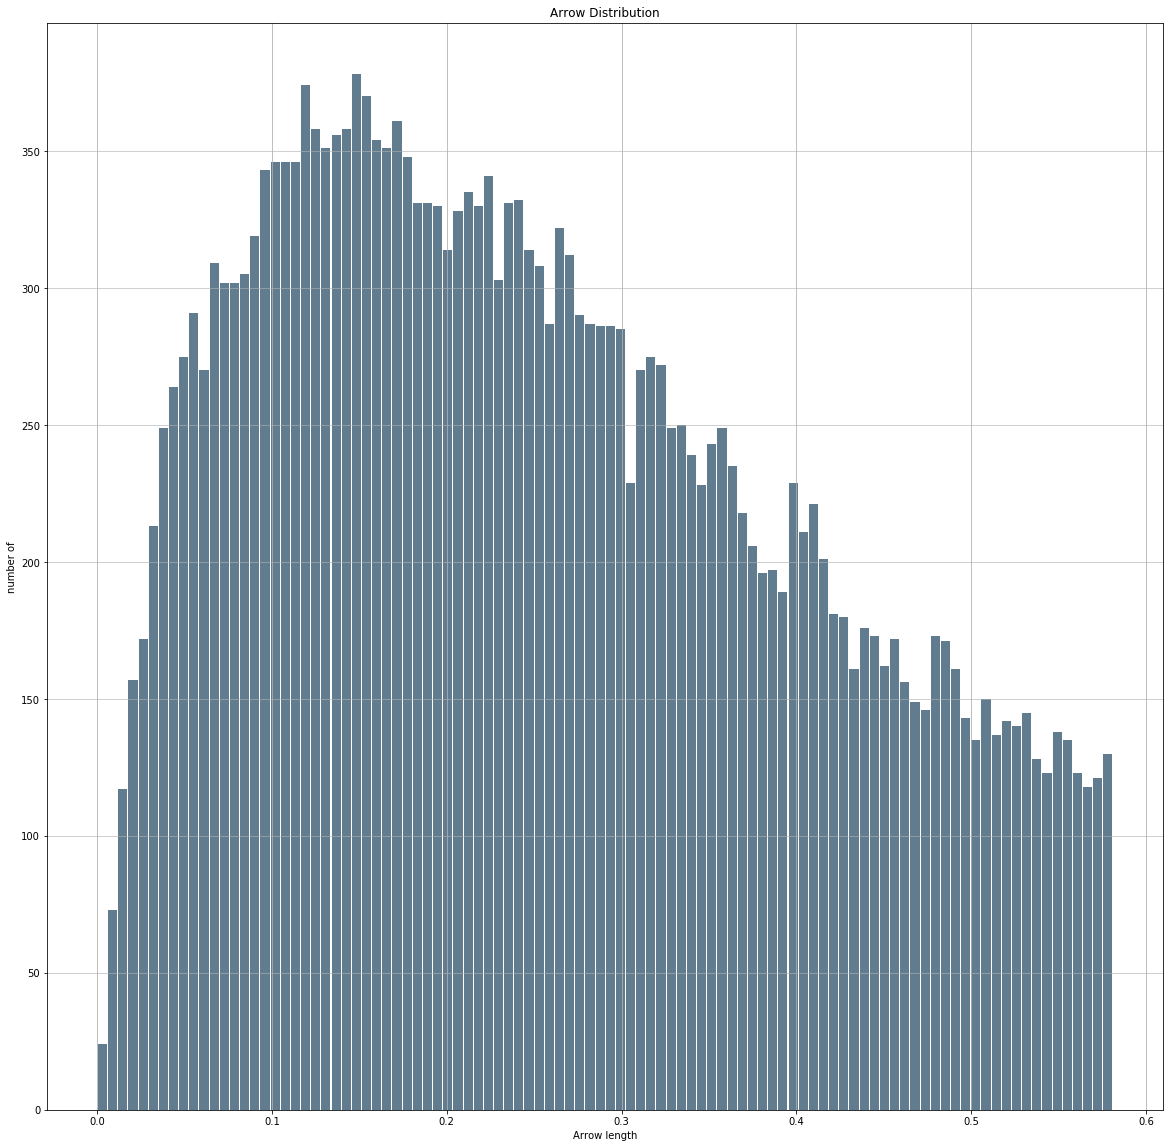

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

commutes = arrowlength['distance']

commutes.plot.hist(grid=True, bins=100, rwidth=0.9,
                   color='#607c8e')
plt.title('Arrow Distribution')
plt.xlabel('Arrow length')
plt.ylabel('number of')
plt.grid(axis='y', alpha=0.75)
plt.show()

# set normalization cap for the above plot

In [119]:
cap = max(arrowlength['distance'])
arrowlength['newdistance'] = arrowlength['distance']
arrowlength['newdistance'].values[arrowlength['newdistance'] > cap] = cap

In [120]:
arrowlength['newdistance'] = arrowlength['newdistance']/(cap*3)

In [121]:
coordinates = []
for index, row in arrowlength.iterrows():
    t = row['newdistance']/row['distance']
    xcoord = ((1-t)*row['startingPoint'][0])+(t * row['endPoint'][0])
    ycoord = ((1-t)*row['startingPoint'][1])+(t * row['endPoint'][1])
    coords = (xcoord, ycoord)
    coordinates.append(coords)
arrowlength['new_endpoint'] = pd.Series(coordinates)

In [122]:
arrowlength.head()

,distance,startingCell,startingPoint,endPoint,newdistance,new_endpoint
0,0.250741,R1.01.R2.01.R3.06.P1.07,"(6.59491209996567, -9.48476083204823)","(6.369304824651999, -9.594178308771118)",0.143834,"(6.46549538835877, -9.547526760186464)"
1,0.227026,R1.01.R2.03.R3.68.P1.07,"(6.102664354598191, -9.64732072932513)","(6.305649766520302, -9.748995666278326)",0.130231,"(6.219104325244562, -9.705645249113008)"
2,0.204265,R1.01.R2.05.R3.15.P1.05,"(6.693468208827361, -9.509410383229019)","(6.615385630633543, -9.698162465291867)",0.117174,"(6.6486771421847495, -9.617685587278032)"
3,0.208040,R1.01.R2.05.R3.40.P1.07,"(6.46493742062397, -9.58470817755299)","(6.5410346587015535, -9.391085319924581)",0.119339,"(6.508589622445369, -9.473638915751213)"
4,0.210339,R1.01.R2.05.R3.49.P1.07,"(6.867136780829201, -9.76010490038398)","(6.687321326984599, -9.869233699888357)",0.120659,"(6.763987958610078, -9.82270523254893)"


# smooth arrows for 15 knn

In [123]:
arrowknn = arrowlength[['startingCell', 'startingPoint']]

In [124]:
arrowknn['startx'] = [i[0] for i in arrowknn['startingPoint']]
arrowknn['starty'] = [i[1] for i in arrowknn['startingPoint']]
arrowknn.head()

/Users/wongw5/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/wongw5/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,startingCell,startingPoint,startx,starty
0,R1.01.R2.01.R3.06.P1.07,"(6.59491209996567, -9.48476083204823)",6.594912,-9.484761
1,R1.01.R2.03.R3.68.P1.07,"(6.102664354598191, -9.64732072932513)",6.102664,-9.647321
2,R1.01.R2.05.R3.15.P1.05,"(6.693468208827361, -9.509410383229019)",6.693468,-9.509410
3,R1.01.R2.05.R3.40.P1.07,"(6.46493742062397, -9.58470817755299)",6.464937,-9.584708
4,R1.01.R2.05.R3.49.P1.07,"(6.867136780829201, -9.76010490038398)",6.867137,-9.760105


In [125]:
arrowknn.index = arrowknn['startingCell']
arrowknn = arrowknn[['startx', 'starty']]

In [126]:
arrowknn = sk.kneighbors_graph(arrowknn, mode='connectivity', n_neighbors=15)

In [127]:
arrowknn

<24341x24341 sparse matrix of type '<class 'numpy.float64'>'
	with 365115 stored elements in Compressed Sparse Row format>

In [128]:
arrowknn.columns = arrowlength['startingCell'].tolist()
arrowknn.rows = arrowlength['startingCell'].tolist()

In [129]:
arrowdict = {}
for i in range(len(arrowknn.rows)):
    row = arrowknn.tocsr()[i, :].toarray()
    indexes = []
    for j in range(len(row[0])):
        if row[0][j] > 0:
            indexes.append(j)
    arrowdict[arrowknn.rows[i]] = indexes

In [130]:
#arrowset should be list of the starting and end coordinates of arrows [((start1,start2), (end1, end2)), ...]
def ArrowAverage(arrowset):
    startones = np.mean([i[0][0] for i in arrowset])
    starttwos = np.mean([i[0][1] for i in arrowset])
    endones = np.mean([i[1][0] for i in arrowset])
    endtwos = np.mean([i[1][1] for i in arrowset])
    return ((arrowset[0][0][0], arrowset[0][0][1]), (endones, endtwos))

In [131]:
def AvgTowardsArrow(pointstart, starter, adf, knn):
    val = pointstart
    inds = knn.get(val)
    bigset = [i for i in arrowknn.rows if i in inds]
    total = [starter]
    location = adf[adf['startingCell'].isin(bigset)]
    sta = [i for i in location['startingPoint']]
    end = [i for i in location['new_endpoint']]
    #print(bigset)
    #print()
    #print(sta)
    #print(end)
    [total.append((sta[p], end[p])) for p in range(len(sta))] 
    #print(total)
    return total

In [132]:
def smootharrowscores(dataframe, knn):
    count = 0
    #dataframe is a dataframe with columns startingPoint, new_endpoint, starting_cell
    print(len(dataframe.index))
    newmat = []
    for index, row in dataframe.iterrows():
        rep = (row['startingPoint'], row['new_endpoint'])
        #print(rep)
        newrep = ArrowAverage(AvgTowardsArrow(row['startingCell'], rep, dataframe, knn))
        #print(newrep)
        newmat.append(newrep)    
        
        #genename = key
        #geneind2 = [j for j, e in enumerate(tempy) if i == e]
        #corr = counts.tocsr()[geneind2, : ]
        #corr = corr.toarray()
        if count % 10000 == 0:
            print(len(newmat))
        count += 1
    
    return(newmat)

In [133]:
forthearrowlength = smootharrowscores(arrowlength, arrowdict)
arrowlength['newestcoords'] = forthearrowlength

24341
1
10001
20001


# getting only the cells that we are interested in

In [134]:
tomerge = pd.read_csv('cells_of_interest.txt', sep = '\t', header = None)
tomerge.columns = ['atac', 'rna', 'celltype']


In [135]:
tomerge.head()

,atac,rna,celltype
0,R1.01.R2.03.R3.61.P1.06,R1.01.R2.03.R3.61.P1.54,Medulla
1,R1.01.R2.26.R3.65.P1.06,R1.01.R2.26.R3.65.P1.54,Medulla
2,R1.01.R2.67.R3.47.P1.07,R1.01.R2.67.R3.47.P1.55,Medulla
3,R1.01.R2.68.R3.20.P1.08,R1.01.R2.68.R3.20.P1.56,Medulla
4,R1.01.R2.71.R3.73.P1.07,R1.01.R2.71.R3.73.P1.55,Medulla


In [136]:
arrowlength2 = arrowlength[arrowlength['startingCell'].isin(set(tomerge['atac'].tolist()))]

In [137]:
tomerge.columns = ['startingCell', 'rna', 'celltype']



In [138]:
arrowlength2 = arrowlength2.merge(tomerge, on = 'startingCell')

In [139]:
arrowlength2.head()

,distance,startingCell,startingPoint,endPoint,newdistance,new_endpoint,newestcoords,rna,celltype
0,0.078589,R1.01.R2.01.R3.43.P1.08,"(-0.41464373271544797, 1.4653588840799299)","(-0.33757234919271834, 1.449986739151499)",0.045082,"(-0.3704327248894008, 1.4565408508661681)","((-0.41464373271544797, 1.4653588840799299), (...",R1.01.R2.01.R3.43.P1.56,TAC-1
1,0.020023,R1.01.R2.06.R3.83.P1.07,"(-9.87718090730019, -2.4981159811425497)","(-9.890956538236399, -2.5126464659268564)",0.011486,"(-9.885083120797496, -2.5064512068405)","((-9.87718090730019, -2.4981159811425497), (-9...",R1.01.R2.06.R3.83.P1.55,TAC-1
2,0.061909,R1.01.R2.11.R3.86.P1.08,"(-9.79219595975282, -2.57662462754936)","(-9.853914316628869, -2.581485004157619)",0.035514,"(-9.827599901321523, -2.5794127200740244)","((-9.79219595975282, -2.57662462754936), (-9.8...",R1.01.R2.11.R3.86.P1.56,TAC-1
3,0.221326,R1.01.R2.15.R3.09.P1.07,"(-8.49143176738649, -5.31811987139297)","(-8.656672268381541, -5.170875433013103)",0.126961,"(-8.586219855374008, -5.233654993250042)","((-8.49143176738649, -5.31811987139297), (-8.5...",R1.01.R2.15.R3.09.P1.55,TAC-1
4,0.030240,R1.01.R2.17.R3.81.P1.05,"(-9.79411585692249, -2.38504058417368)","(-9.76974013339897, -2.402936296952506)",0.017347,"(-9.780133036656313, -2.395306229625393)","((-9.79411585692249, -2.38504058417368), (-9.7...",R1.01.R2.17.R3.81.P1.53,TAC-1


# plot arrows over umap

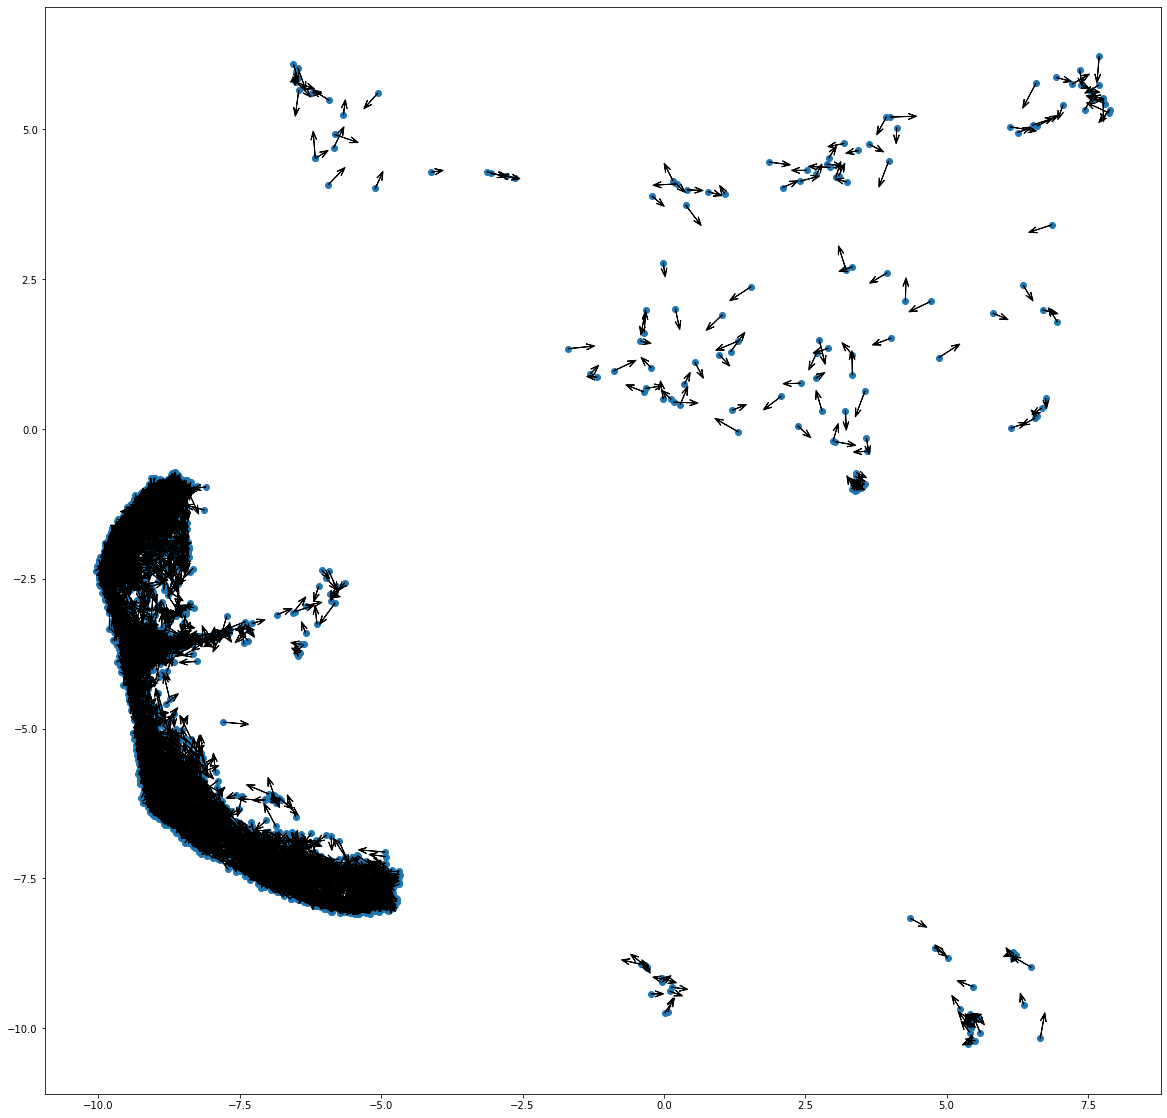

In [140]:
import matplotlib.pyplot as plt

start = [i[0] for i in arrowlength2['startingPoint']]
startend = [i[1] for i in arrowlength2['startingPoint']]

#end = [i[1] for i in arrowlength['endPoint']]
#endstart = [i[0] for i in arrowlength['endPoint']]

end = [i[1] for i in arrowlength2['new_endpoint']]
endstart = [i[0] for i in arrowlength2['new_endpoint']]

#start = [start[i] for i in range(len(start)) if i % 10 == 0]
#startend = [startend[i] for i in range(len(startend)) if i % 10 == 0]
#endstart = [endstart[i] for i in range(len(endstart)) if i % 10 == 0]
#end = [end[i] for i in range(len(end)) if i % 10 == 0]
#plt.xlim(-1, 4)
#plt.ylim(3, 14)
plt.scatter(start, startend)
#plt.scatter(endstart, end)
for i in range(len(start)):
    plt.arrow(start[i], startend[i], endstart[i]-start[i], end[i]-startend[i], overhang = 0.8, head_width = 0.1, head_length = 0.15, joinstyle = 'miter')
plt.show()

In [141]:
startmedulla = [i[0] for i in arrowlength2[arrowlength2['celltype'] == 'Medulla']['startingPoint']]
startendmedulla = [i[1] for i in arrowlength2[arrowlength2['celltype'] == 'Medulla']['startingPoint']]
starttac1 = [i[0] for i in arrowlength2[arrowlength2['celltype'] == 'TAC-1']['startingPoint']]
startendtac1 = [i[1] for i in arrowlength2[arrowlength2['celltype'] == 'TAC-1']['startingPoint']]
startendcortex = [i[1] for i in arrowlength2[arrowlength2['celltype'] == 'Hair Shaft-cuticle.cortex']['startingPoint']]
startcortex = [i[0] for i in arrowlength2[arrowlength2['celltype'] == 'Hair Shaft-cuticle.cortex']['startingPoint']]
startendirs = [i[1] for i in arrowlength2[arrowlength2['celltype'] == 'IRS']['startingPoint']]
startirs = [i[0] for i in arrowlength2[arrowlength2['celltype'] == 'IRS']['startingPoint']]
starttac2 = [i[0] for i in arrowlength2[arrowlength2['celltype'] == 'TAC-2']['startingPoint']]
startendtac2 = [i[1] for i in arrowlength2[arrowlength2['celltype'] == 'TAC-2']['startingPoint']]


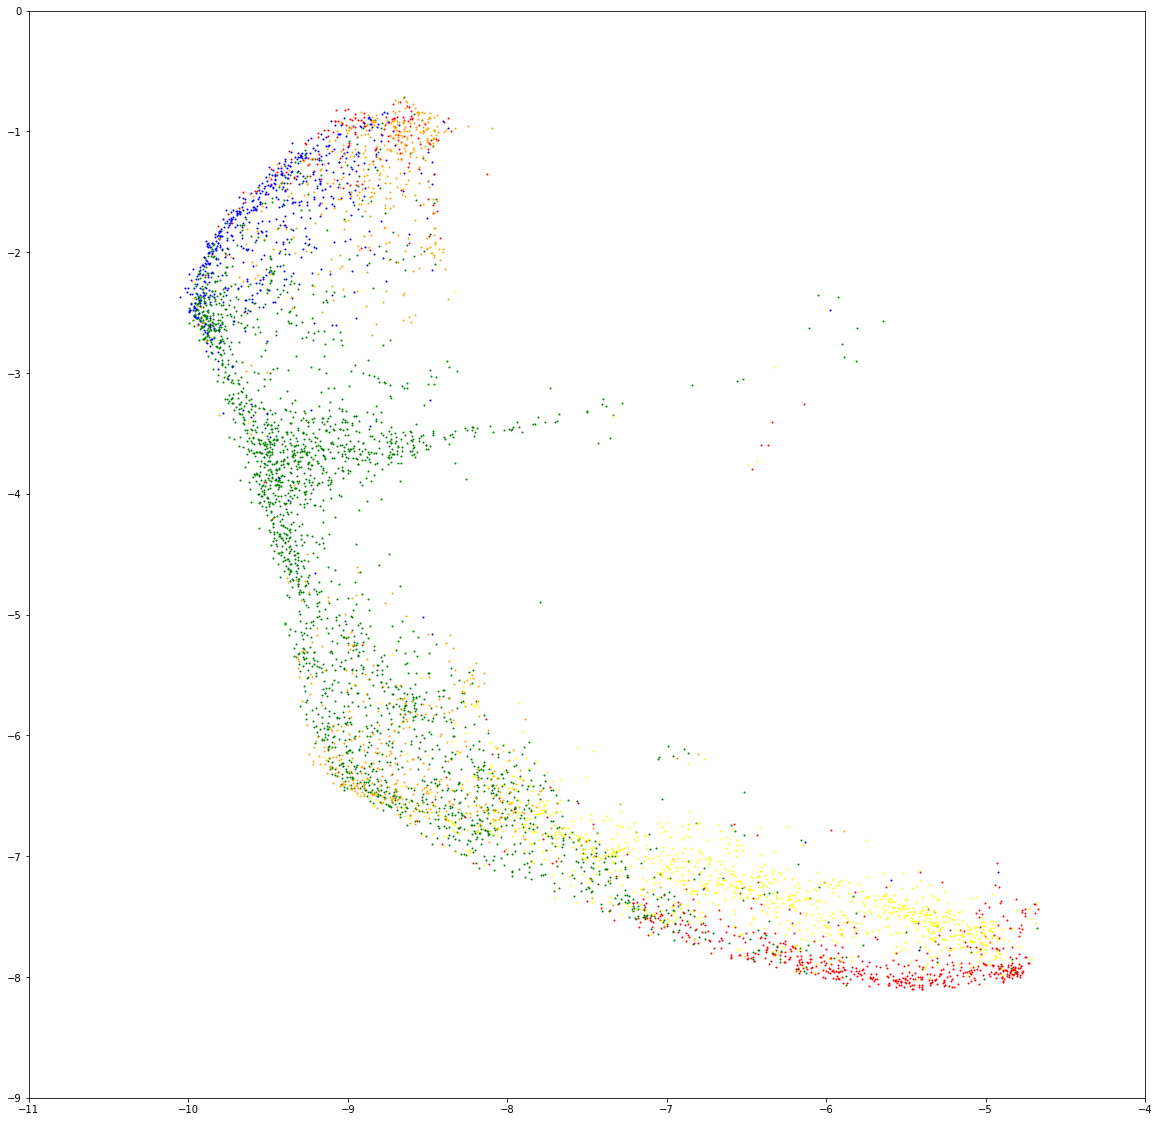

In [142]:
import matplotlib.pyplot as plt



#end = [i[1] for i in arrowlength['endPoint']]
#endstart = [i[0] for i in arrowlength['endPoint']]

end = [i[1] for i in arrowlength2['new_endpoint']]
endstart = [i[0] for i in arrowlength2['new_endpoint']]

#start = [start[i] for i in range(len(start)) if i % 10 == 0]
#startend = [startend[i] for i in range(len(startend)) if i % 10 == 0]
#endstart = [endstart[i] for i in range(len(endstart)) if i % 10 == 0]
#end = [end[i] for i in range(len(end)) if i % 10 == 0]
plt.xlim(-11, -4)
plt.ylim(-9, 0)
plt.scatter(startmedulla, startendmedulla, color = 'red', s=1)
plt.scatter(starttac1, startendtac1, color = 'green', s=1)
plt.scatter(startcortex, startendcortex, color = 'yellow', s=1)
plt.scatter(startirs, startendirs, color = 'blue', s=1)
plt.scatter(starttac2, startendtac2, color = 'orange', s=1)
#plt.scatter(endstart, end)

#for i in range(len(start)):
#    plt.arrow(start[i], startend[i], endstart[i]-start[i], end[i]-startend[i], overhang = 0.8, head_width = 0.1, head_length = 0.15, joinstyle = 'miter')
plt.show()

In [143]:
def GridMap(ycoords, xcoords, arrowframe):
    tore = {}
    ypos = [i for i in np.arange(ycoords[0], ycoords[1], round((ycoords[1]-ycoords[0])/40, 2))]
    xpos = [i for i in np.arange(xcoords[0], xcoords[1], round((xcoords[1]-xcoords[0])/40, 2))]
    for i in ypos:
        for j in xpos:
            tore[(i, j)] = []
    for index, row in arrowframe.iterrows():
        co = row['startingPoint']
        xco = co[0]
        yco = co[1]
        yhold = -1
        xhold = -1
        for i in range(1, len(ypos)):
            if yco < ypos[0]:
                break
            if yco < ypos[i]:
                yhold = ypos[i - 1]
                break
                
        for i in range(1, len(xpos)):
            if xco < xpos[0]:
                break
            if xco < xpos[i]:
                xhold = xpos[i - 1]
                break
        if xhold != -1 and yhold != -1:
            #print(yhold, xhold)
            tore[(yhold, xhold)].append(index)  
    return tore

In [144]:
gmap = GridMap((-9, 0), (-11, -4), arrowlength2)

In [145]:
gmap2 = {}
for i in gmap:
    indexes = gmap.get(i)
    if len(indexes) > 0:
        rowsa = arrowlength2.iloc[indexes]
        #print(rowsa)
        sp = [v[0] for v in rowsa['newestcoords']]
        #print(sp)
        en = [v[1] for v in rowsa['newestcoords']]
        both = [(sp[v], en[v]) for v in range(len(sp))]
        #print(rowsa['cp'].tolist())
        gmap2[i] = ArrowAverage(both)
    else:
        gmap2[i] = None

In [146]:
gmap2arrows = []
for i in gmap2:
    if gmap2.get(i) != None:
        gmap2arrows.append(gmap2.get(i))

In [147]:
plt.rcParams["figure.figsize"] = (20,20)

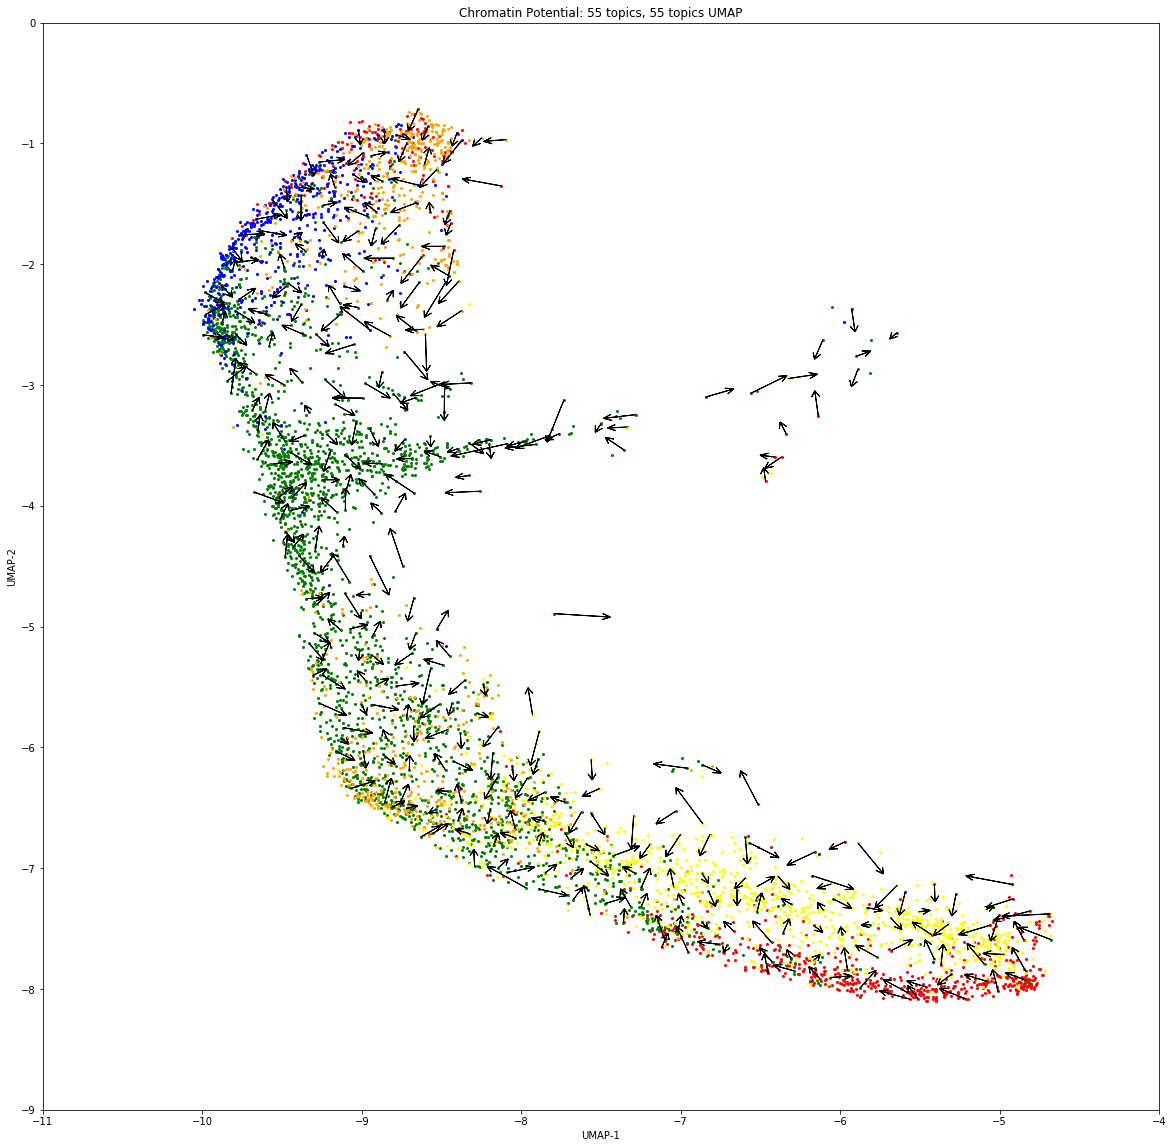

In [210]:
import matplotlib.pyplot as plt



#end = [i[1] for i in arrowlength['endPoint']]
#endstart = [i[0] for i in arrowlength['endPoint']]

end = [i[1] for i in arrowlength2['new_endpoint']]
endstart = [i[0] for i in arrowlength2['new_endpoint']]

#start = [start[i] for i in range(len(start)) if i % 10 == 0]
#startend = [startend[i] for i in range(len(startend)) if i % 10 == 0]
#endstart = [endstart[i] for i in range(len(endstart)) if i % 10 == 0]
#end = [end[i] for i in range(len(end)) if i % 10 == 0]
plt.xlim(-11, -4)
plt.ylim(-9, 0)
plt.rcParams["figure.figsize"] = (20,20)
start = [i[0] for i in arrowlength['startingPoint']]
startend = [i[1] for i in arrowlength['startingPoint']]
#plt.scatter(start, startend, s=4)
plt.scatter(startmedulla, startendmedulla, color = 'red', s=4)
plt.scatter(starttac1, startendtac1, color = 'green', s=4)
plt.scatter(startcortex, startendcortex, color = 'yellow', s=4)
plt.scatter(startirs, startendirs, color = 'blue', s=4)
plt.scatter(starttac2, startendtac2, color = 'orange', s=4)

plt.title('Chromatin Potential: 55 topics, 55 topics UMAP')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
#plt.scatter(endstart, end)

for i in range(len(gmap2arrows)):
    #if math.sqrt((gmap2arrows[i][1][0] - gmap2arrows[i][0][0])**2 + (gmap2arrows[i][1][1] - gmap2arrows[i][0][1])**2) < 0.3:
    plt.arrow(gmap2arrows[i][0][0], gmap2arrows[i][0][1], gmap2arrows[i][1][0]-gmap2arrows[i][0][0], gmap2arrows[i][1][1]-gmap2arrows[i][0][1], overhang = 1.0, head_width = 0.05, head_length = 0.05, width = 0.00001, joinstyle = 'miter')
plt.show()

In [149]:
#can try doing knns only with the hair follicle data
#also can try filtering out arroes of specific length